# Проект Телеком.

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Нашей задачей является разработка прототипа модели, которая подскажет с кем из клиентов следует поработать над удержанием, чтобы они не ушли от заказчика.

### План работы.

* __Подготовка данных__
  * __Знакомство с данными__ (подгрузка файлов, изучение предоставленных данных, построение графиков распределения признаков)
  * __Предобработка данных__ (поиск аномальных значений признаков, слияние датафреймов, заполнение пропусков, преобразование типов и нормализация)
  * __Исследовательский анализ данных__ (визуализация данных, поиск корреляций между признаками)
  * __Подготовка данных для моделей машинного обучения__ (разделение на выборки, кодирование, масштабирование)<br><br>
* __Создание моделей__ (логистическая регрессия, random forest, градиентный бустинг, возможно нейросеть)
  * __Поиск лучших гипперпараметров каждой модели__
  * __Сравнение метрик моделей на кросс-валидации__
  * __Тестирование лучшей модели__
  * __Исследование важности признаков для лучшей модели__

## Подготовка данных.

### Знакомство с данными.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, recall_score, precision_score
from phik import phik_matrix
from phik import resources, report

Предоставленные данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Рассмотрим файлы с данными и изучим общую информацию.

In [2]:
try:
    path = 'D:\Document\Jupyter Notebook\datasets\\'
    contract = pd.read_csv(path + 'contract.csv')
    personal = pd.read_csv(path + 'personal.csv')
    internet = pd.read_csv(path + 'internet.csv')
    phone = pd.read_csv(path + 'phone.csv')
    
except:
    path = '/datasets/final_provider/'
    contract = pd.read_csv(path + 'contract.csv')
    personal = pd.read_csv(path + 'personal.csv')
    internet = pd.read_csv(path + 'internet.csv')
    phone = pd.read_csv(path + 'phone.csv')

#### contract.csv — информация о договоре

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


В файле с информацией о договорах клиентов в столбце `BeginDate` содержится дата начала сотрудничества с компанией, а в столбце `EndDate` дата расторжения договора для клиентов решивших прекратить сотрудничество. На основе данных столбцов мы можем создать новый целевой категориальный признак, который будет отражать намерение клиента прекратить сотрудничество с компанией.

Чтобы не допустить утечки данных мы удалим данные столбцы на этапе предобработки данных, а чтобы не потерять важную информацию о времени сотрудничества клиента с компанией, создадим новый столбец с количеством дней с момента заключения договора до момента его расторжения или до момента для которого данные были актуальны (в нашем случае - до 1 февраля 2020).

В файле также содержится информация о типе оплаты, размере оплаты и общая сумма оплаты услуг клиентом в рамках договора.



In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract['customerID'].duplicated().sum()

0

В данном файле содержится 7043 уникальные записи. Некоторые стобцы имеют некорректный тип данных, так, например, столбец `TotalCharges` является строковым типом данных, несмотря на то, что отражает общую прибыль.

Построим графики распределений признаков. Для этого нам необходимо привести столбец `TotalCharges` к числовому типу данных.

In [6]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

В колонке были обнаружены недопустимые значение, которые мы заменили на значение "NaN", мы вернемся к данным строкам на этапе предобработки данных.

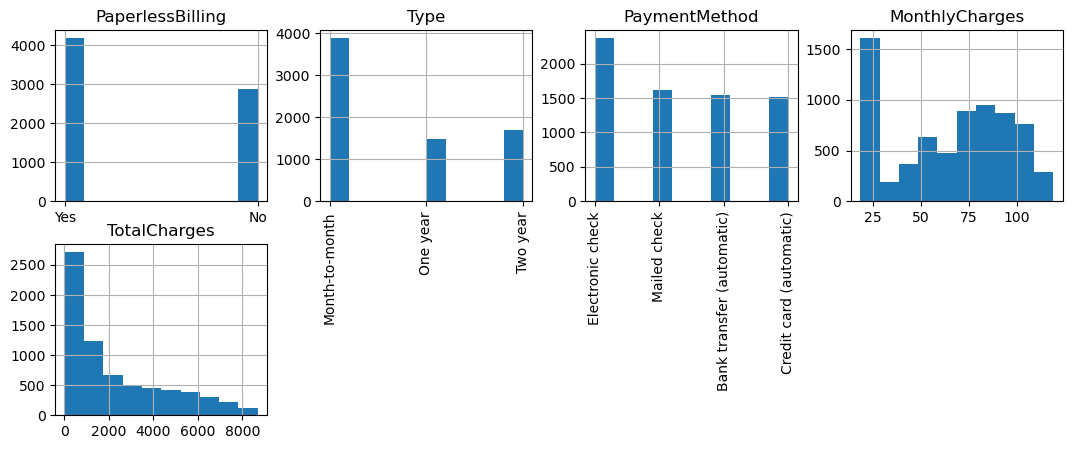

In [7]:
fig = plt.figure(figsize=(13, 5))
fig.subplots_adjust(wspace=0.25, hspace=0.25)

fig.add_subplot(2, 4, 1)
plt.hist(contract['PaperlessBilling'])
plt.grid()
plt.title('PaperlessBilling')

fig.add_subplot(2, 4, 2)
plt.hist(contract['Type'])
plt.grid()
plt.title('Type')
plt.xticks(rotation=90)

fig.add_subplot(2, 4, 3)
plt.hist(contract['PaymentMethod'])
plt.grid()
plt.title('PaymentMethod')
plt.xticks(rotation=90)

fig.add_subplot(2, 4, 4)
plt.hist(contract['MonthlyCharges'])
plt.grid()
plt.title('MonthlyCharges')

fig.add_subplot(2, 4, 5)
plt.hist(contract['TotalCharges'])
plt.grid()
plt.title('TotalCharges')

plt.show()

На графиках можно заметить, что большинство клиентов предпочитают ежемесячную оплату, вместо оплаты за год или два. Большинство клиентов предпочитают оплату с помощью электронного чека. Количество клиентов предпочитающих безбумажное выставление счета на 25% больше количества клиентов, которым необходимо бумажное выставление счета. На графике с суммой ежемесячной оплаты клиентов можно заметить выброс в значении до 30. График с общей суммой распределен со скосом вправо.

Отдельно рассмотрим графики с датой заключения и расторжения договоров. Для этого необходимо преобразовать даты из строковых типов в формат даты.

In [8]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

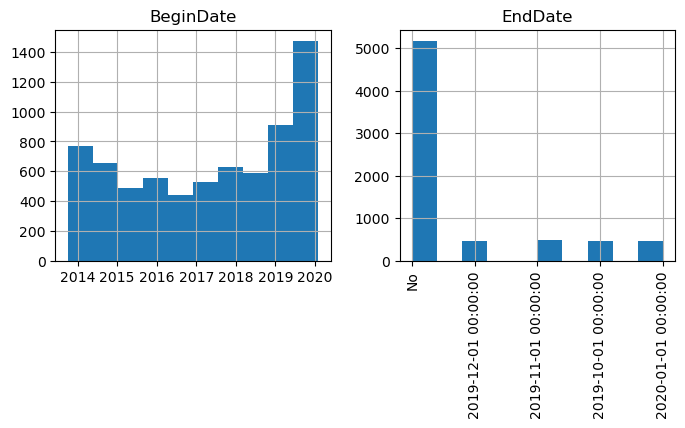

In [9]:
fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(wspace=0.25, hspace=0.25)

fig.add_subplot(1, 2, 1)
plt.hist(contract['BeginDate'])
plt.grid()
plt.title('BeginDate')

fig.add_subplot(1, 2, 2)
plt.hist(contract['EndDate'])
plt.grid()
plt.xticks(rotation=90)
plt.title('EndDate')

plt.show()

На графиках можно заметить приток клиентов в 2020 году, что вероятно объясняет выбросы на графиках с небольшой суммой ежемесячной и общей оплаты. Удивляет тот факт, что несмотря на то что компания начала заключать договоры с клиентами примерно с 2014 года, расторжение контрактов приходится лишь на последние 4 месяца с момента выгрузки данных. Может быть компания ранее не вела учет даты расторжения договора клиентов? Следовало бы уточнить данный вопрос

#### personal.csv — персональные данные клиента

In [10]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


В признаках можно заметить, что категориальные признаки заполнены разными способами: в столбце `SeniorCitizen` данные заполнены с помощью 0 и 1, в других случаях данные заполнены значениями "Yes" или "No". На этапе предобработки данных мы приведем данные к единому значению.

In [11]:
personal['customerID'].duplicated().sum()

0

In [12]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Файл с персональными данными о клиентах также содержит 7043 уникальные записи.

Построим графики распределений признаков.

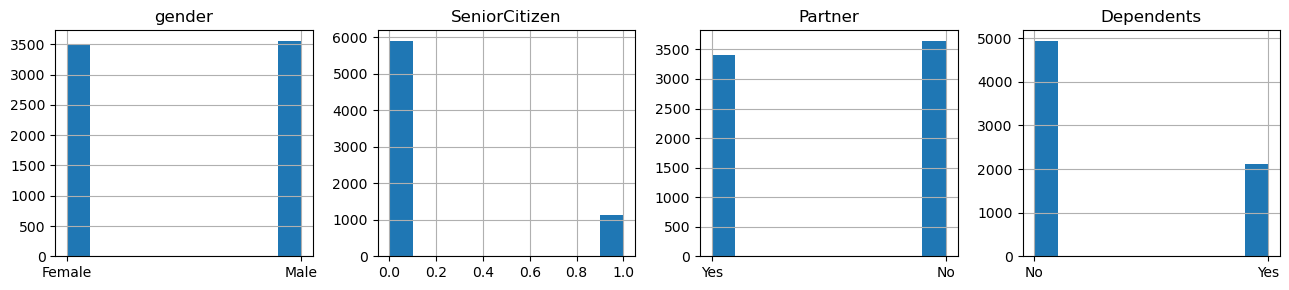

In [13]:
fig = plt.figure(figsize=(13, 3))
for i in range(1, 5):
    fig.add_subplot(1, 4, i)
    plt.hist(personal[personal.columns[i]])
    plt.grid()
    plt.title(personal.columns[i])
    plt.tight_layout()

На графиках можно заметить равное распределение в столбцах `gender` и `Partner`. Количество пенсионеров примерно в 6 раз меньше клиентов непенсионеров. Количество клиентов примерно содержащих иждевенцев в 2.5 раза меньше клиентов без иждевенцев.

#### internet.csv — информация об интернет-услугах

In [14]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [15]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [16]:
internet['customerID'].duplicated().sum()

0

Файл с информацией об интернет-услугах содержит 5517 строк с уникальными записями о клиентах, которые пользуются услугами интернета. Столбец `InternetService` представляет собой информацию о типе подключения, остальные столбцы отображают информацию о дополнительных услугах.

Построим графики распределений признаков.

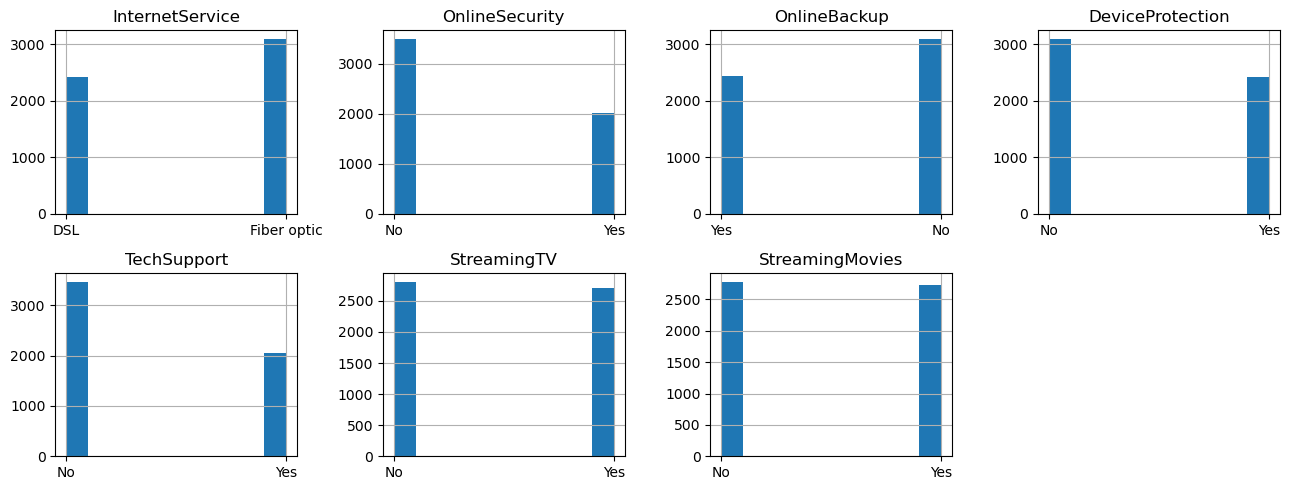

In [17]:
fig = plt.figure(figsize=(13, 5))
for i in range(1, 8):
    fig.add_subplot(2, 4, i)
    plt.hist(internet[internet.columns[i]])
    plt.grid()
    plt.title(internet.columns[i])
    plt.tight_layout()

На графиках можно заметить, что клиентов предпочитающих подключение через оптоволоконный кабель примерно на 20% больше, чем клиентов использующих телефонную линию в качестве соединения. Половина клиентов пользуются услугами стримингов. Большинство клиентов не пользуются услугами интернет-безопасности и услугами облачного резервного копирования данных.

#### phone.csv — информация об услугах телефонии

In [18]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [19]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [20]:
phone['customerID'].duplicated().sum()

0

Файл с информацией об услугах телефонии содержит 6361 строк с уникальными записями о клиентах, которые пользуются услугами телефонии. В столбце `MulltipleLines` отображена информация об использовании нескольких линий связи.

Построим график распределения признака.

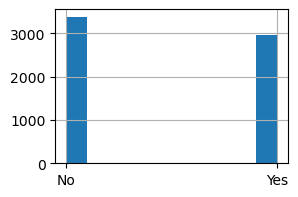

In [21]:
phone['MultipleLines'].hist(figsize=(3, 2))
plt.show()

На графике можно заметить небольшой перевес в сторону клиентов не пользующихся услугами нескольких линий телефонной связи.

#### Выводы.

Для построения модели нам были предоставлены файлы с информацией о договоре, персональные данные клиента, информация об интернет-услугах, информация об услугах телефонии.

Мы рассмотрели файлы с данными и изучили общую информацию.

В файле с информацией о договорах клиентов на графиках мы заметили, что большинство клиентов предпочитают ежемесячную оплату, вместо оплаты за год или два. Большинство клиентов предпочитают оплату с помощью электронного чека. Количество клиентов предпочитающих безбумажное выставление счета на 25% больше количества клиентов, которым необходимо бумажное выставление счета. На графике с суммой ежемесячной оплаты клиентов мы смогли заметить выброс в значении до 30. График с общей суммой распределен со скосом вправо. На графиках с датами можно было заметить приток клиентов в 2020 году, что вероятно объясняет выбросы на графиках с небольшой суммой ежемесячной и общей оплаты. Нас удивил тот факт, что несмотря на то что компания начала заключать договоры с клиентами примерно с 2014 года, расторжение контрактов приходится лишь на последние 4 месяца с момента выгрузки данных.

На графиках файла с персональной информацией о клиентах мы смогли заметить равное распределение в столбцах `gender` и `Partner`. Количество пенсионеров примерно в 6 раз меньше клиентов непенсионеров. Количество клиентов примерно содержащих иждевенцев в 2.5 раза меньше клиентов без иждевенцев.

В файле с информацией об интернет-услугах мы смогли заметить, что клиентов предпочитающих подключение через оптоволоконный кабель примерно на 20% больше, чем клиентов использующих телефонную линию в качестве соединения. Половина клиентов пользуются услугами стримингов. Большинство клиентов не пользуются услугами интернет-безопасности и услугами облачного резервного копирования данных. Файл с информацией об интернет-услугах содержит 5517 строк с уникальными записями о клиентах.

Файл с информацией об услугах телефонии содержит 6361 строк с уникальными записями о клиентах. На графике мы смогли заметить небольшой перевес в сторону клиентов не пользующихся услугами нескольких линий телефонной связи.

### Предобработка данных.

#### Создание новых признаков.

На этапе знакомства с данными мы решили, что для создания целевого признака отражающего намерение клиента прекратить сотрудничество с компанией будет использована колонка `EndDate` из файла с информацией о договорах клиентов. На данный момент колонка содержит либо дату расторжения договора с клиентом, либо значение "No", подразумевающее, что клиент продолжает пользоваться услугами компании. 

Создадим новый целевой категориальный признак `churn`, в котором значение "Yes" означает, что клиент отказался от услуг компании, а значение "No" - клиент продолжает пользоваться услугами компании.

In [22]:
contract['churn'] = contract['EndDate'].transform(lambda x: 'No' if x == 'No' else 'Yes')

Так как полученный целевой признак связан с другим признаком, при построении модели будет происходить утечка данных. Чтобы этого не допустить, нам придется избавиться от колонки `EndDate`, однако колонка содержит важную информацию с помощью которой можно вычислить время сотрудничество клиента с компанией. 

Чтобы сохранить информацию о времени сотрудничества клиента с компанией, создадим новый признак `tenure`, значениями которого будут количество дней с момента заключения договора до момента его расторжения или до момента для которого данные были актуальны (в нашем случае - до 1 февраля 2020).

In [23]:
# меняем значение 'No' на дату выгрузки данных.
contract['EndDate'] = contract['EndDate'].transform(lambda x: '2020-02-01' if x == 'No' else x)
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

# высчитываем количество дней действия договора и приводим к типу int64
contract['tenure'] = contract['EndDate'] - contract['BeginDate']
contract['tenure'] = contract['tenure'] / np.timedelta64(1, 'D')
contract['tenure'] = contract['tenure'].astype('int64')

# удаляем колонки с датами "EndDate" и "BeginDate"
contract = contract.drop(['EndDate', 'BeginDate'], axis=1)

Таким образом мы смогли сохранить важную информацию о количестве дней действия договора и предотвратили утечку данных.

#### Работа с пропусками.

На этапе знакомства с файлами в одной из колонок были обнаружены некорректные значения. В колонке `TotalCharges` мы заменили такие значения на "NaN".

Рассмотрим строки с данным значением.

In [24]:
contract[contract['TotalCharges'].isna()]

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,tenure
488,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,0
753,3115-CZMZD,Two year,No,Mailed check,20.25,NaN,No,0
936,5709-LVOEQ,Two year,No,Mailed check,80.85,NaN,No,0
1082,4367-NUYAO,Two year,No,Mailed check,25.75,NaN,No,0
1340,1371-DWPAZ,Two year,No,Credit card (automatic),56.05,NaN,No,0
3331,7644-OMVMY,Two year,No,Mailed check,19.85,NaN,No,0
3826,3213-VVOLG,Two year,No,Mailed check,25.35,NaN,No,0
4380,2520-SGTTA,Two year,No,Mailed check,20.00,NaN,No,0
5218,2923-ARZLG,One year,Yes,Mailed check,19.70,NaN,No,0
6670,4075-WKNIU,Two year,No,Mailed check,73.35,NaN,No,0


Судя по колонке `tenure`, данные клиенты заключили договор в тот же день, в который была произведена выгрузка данных. 

Будет корректным заменить пропущенные данные в колонке с суммой платежей на значение "0". Однако стоит учитывать, что новые клиенты не могут сразу расторгнуть договор с компанией, таким образом они могут негативно сказаться на обучении нашей модели, поэтому более верным решением будет удалить таких клиентов из данных. Мы вернемся к этому после слияния датафреймов, а пока заполним пропуски значением "0".

In [25]:
contract['TotalCharges'].fillna(0, inplace=True)

#### Объединение датафреймов.

Для построения модели и удобства работы с данными мы можем объединить файлы с данными в один датафрейм. 

In [26]:
df = contract.merge(personal, on='customerID', how='outer').merge(internet, on='customerID', how='outer').merge(phone, on='customerID', how='outer')

In [27]:
df.head(3)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,tenure,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,No,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,No,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   churn             7043 non-null   object 
 7   tenure            7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Не все клиенты пользовались одновременно услугами интернета и телефонии, поэтому в некоторых колонках образовались пропуски. 

Так как признаки являются категориальными, будет логичным заменить такие пропуски значениями "No", если клиент действительно не пользуется данными услугами.

In [29]:
df.fillna('No', inplace=True)

Как мы заметили ранее, в данных присутствуют новый клиенты с продолжительностью действия договора равным 0 дней. Проверим сколько клиентов имеют продолжительность действия договора меньше 30 дней и удалим таких клиентов исходя из того, что минимальный срок оплаты по договору составляет один месяц и такие клиенты не могут покинуть компанию раньше оплаченного периода.

In [30]:
len(df[df['tenure'] < 30])

11

Все те же 11 новых клиентов. Удалим данных клиентов из датафрейма.

In [32]:
df.drop(df[df['tenure'] < 30].index, inplace=True)

Колонка с уникальным идентификатором клиента нам больше не понадобится.

In [33]:
df.drop('customerID', axis=1, inplace=True)

Приведем названия колонок к единому виду.

In [34]:
df.rename(columns={'churn': 'Churn', 'tenure': 'Tenure', 'gender': 'Gender'}, inplace=True)

### Итоги.

На этапе предобработки данных мы создали новые признаки: `churn` - целевой категориальный признак отражающий отток клиентов и `tenure` - значениями которого являются количество дней с момента заключения договора до момента его расторжения или до момента для которого данные были актуальны (1 февраля 2020). Также нам пришлось удалить некоторые признаки, чтобы не допустить утечки данных.

В одной из колонок были обнаружены пропуски, строки с которыми мы решили удалить, так как это оказались новые клиенты заключившие договор в тот же день, в который была произведена выгрузка данных.

Для удобства дальнейшей работы мы объединили файлы с данными в один датафрейм.

### Исследовательский анализ данных.

Проведем полноценный исследовательский анализ данных с целью получить более полное представление о данных. 

Для начала рассмотрим новые признаки. `Tenure` отражает количество дней сотрудничества клиента с компанией, `Churn` - целевой признак, сообщающий о том, продолжает ли клиент пользоваться услугами компании.

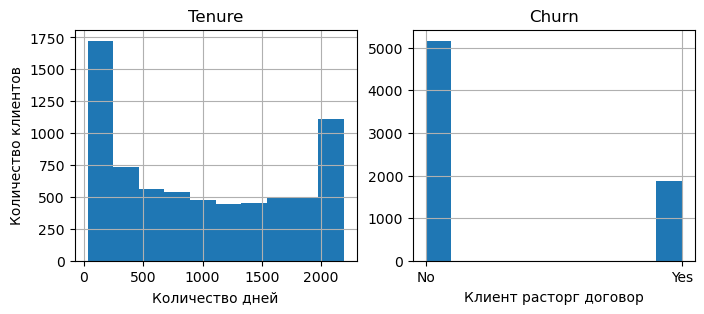

In [35]:
fig = plt.figure(figsize=(8, 3))

fig.add_subplot(1, 2, 1)
df['Tenure'].hist()
plt.title('Tenure')
plt.xlabel('Количество дней')
plt.ylabel('Количество клиентов')

fig.add_subplot(1, 2, 2)
df['Churn'].hist()
plt.title('Churn')
plt.xlabel('Клиент расторг договор')

plt.show()

На графике `Churn` можно заметить, что большинство клиентов в данных продолжает пользоваться услугами компании. Данный признак является целевым и дисбаланс классов при обучении может привести к большому количеству ложноотрицательных результатов. Следует учесть это при построении нашей модели.

В начале и конце графика `Tenure` можно заметить два выброса говорящих о том, что большое количество клиентов сотрудничает с компанией меньше 250 дней, а другое большое количество клиентов пользуется услугами компании уже более 2000 дней. 

Возможно у данного признака имеется корреляция с типом оплаты, так как, вероятно, клиенты которые продолжительное время пользуются услугами компании предпочитают оплату сразу за год или два, а клиенты недавно заключившие договор пользуются помесячной оплатой.

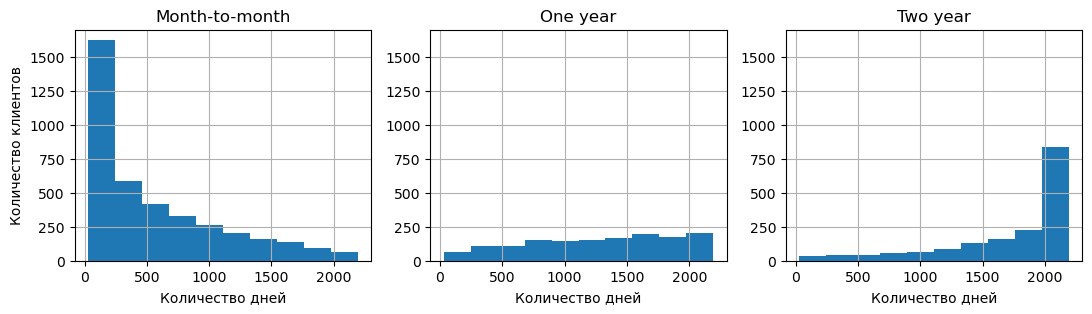

In [36]:
# Сравним продолжительность сотрудничества в зависимости от типа оплаты

fig = plt.figure(figsize=(13, 3))

fig.add_subplot(1, 3, 1)
plt.hist(df[df['Type'] == 'Month-to-month']['Tenure'])
plt.ylim(0, 1700)
plt.grid()
plt.title('Month-to-month')
plt.xlabel('Количество дней')
plt.ylabel('Количество клиентов')

fig.add_subplot(1, 3, 2)
plt.hist(df[df['Type'] == 'One year']['Tenure'])
plt.ylim(0, 1700)
plt.grid()
plt.title('One year')
plt.xlabel('Количество дней')

fig.add_subplot(1, 3, 3)
plt.hist(df[df['Type'] == 'Two year']['Tenure'])
plt.ylim(0, 1700)
plt.grid()
plt.title('Two year')
plt.xlabel('Количество дней')

plt.show()

Действительно, большинство клиентов которые долгое время пользуются услугами компании предпочитают оплату сразу за два года, что говорит об их лояльном отношении к компании. В то же время большинство клиентов недавно заключившие договор выбрали ежемесячный способ оплаты. 

Таким образом между признаками наблюдается корреляция, которая может привести к мультиколлинеарности, что может негативно сказаться для некоторых моделей машинного обучения, в частности для модели логистической регрессии, которую мы собираемся протестировать.

#### Корреляция признаков. 

Проверим корреляцию между признаками с помощью коэффициента phik, который не требует нормального распределения данных, может находить нелинейные зависимости и позволяет работать как с численными, так и с категориальными признаками. Для более наглядной визуализации предварительно закодируем признаки.

Признаки с двумя и более категориями: `Type`, `PaymentMethod`, `InternetService` мы закодируем с помощью техники прямого кодирования. 

Бинарные признаки: `PaperlessBilling`, `Churn`, `Gender`, `SeniorCitizen`, `Partner`, `Dependents`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines` закодируем с помощью порядкового кодирования.

In [37]:
# Кодируем признаки с двумя и более категориями

df_ohe = pd.get_dummies(df, columns=['Type', 'PaymentMethod', 'InternetService'])

# Кодируем бинарные признаки

encoder = OrdinalEncoder()
df_ohe_ord = encoder.fit_transform(df_ohe)
df_ohe_ord = pd.DataFrame(df_ohe_ord, columns=df_ohe.columns)

In [55]:
# Создаем матрицу корреляции

phik_corr_matrix = phik_matrix(df_ohe_ord, interval_cols=['MonthlyCharges', 'TotalCharges', 'Tenure'])

# Для того чтобы график не оказался перегружен отсортируем признаки

phik_corr_matrix = phik_corr_matrix[(phik_corr_matrix >= 0.4) & (phik_corr_matrix != 1)].dropna(how='all').dropna(how='all', axis=1)

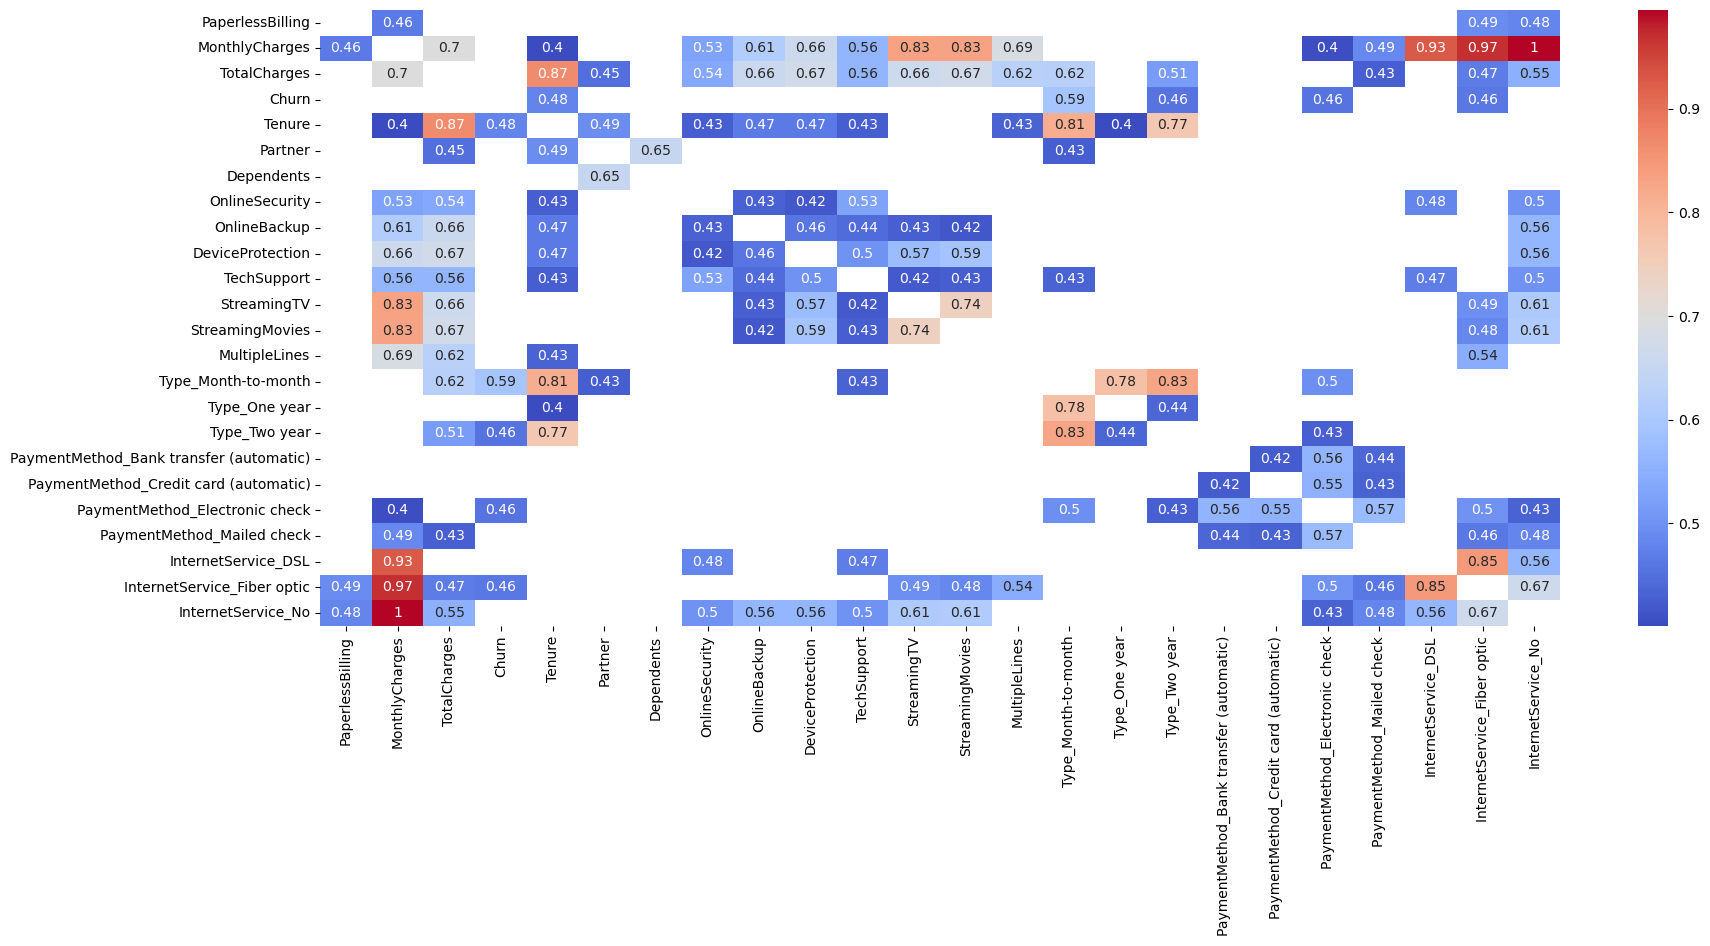

In [45]:
plt.figure(figsize=(20, 8))
sns.heatmap(phik_corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Обычно значения коэффициента корреляции от 0.4 до 0.6 считаются средними, от 0.6 до 0.8 сильными, а свыше 0.8 - очень сильными.

На графике можно заметить, что целевой признак `Churn` коррелирует с типом оплаты, продолжительностью пользования услугами, способом оплаты с помощью электронного чека и подключением интернета с помощью оптоволконного кабеля. В целом создается картина, что клиенты расторгнувшие договор с компанией пользуются услугами компании непродолжительный период и предпочитают ежемесячную оплату, мы еще рассмотрим эту зависимость более детально. Также интересно отметить среднюю зависимость оттока клиентов со способом оплаты с помощью электронного чека, возможно что у клиентов могут возникать какие-то проблемы с данным способом оплаты из-за чего у них может возникнуть намерение отказаться от услуг, компании следует изучить данный вопрос.

На сумму ежемесячной очень сильно влияет наличие и способ интернет соединения, а также опции стримингов. Особо сильная корреляция наблюдается между способом подключения интернета через оптоволоконный кабель и суммой ежемясячной оплаты, учитывая что данный способ подключения наиболее сильно коррелирует со стоимостью ежемясячной оплаты, компании стоит присмотреться к ценовой политике, возможно конкуренты могут предложить более лояльные условия для подключения интернета по оптоволоконному кабелю.

Наличие опции стриминга также сильно коррелирует с опцией подключения антивируса.

Продолжительность пользования услугами сильно коррелирует с типом оплаты - ежемесячной или оплатой за два года. Клиенты предпочитающие тип оплаты за два года очевидно пользуются услугами компании дольше, в то же время клиенты с ежемесячным типом оплаты больше подвержены оттоку.

Из интересного можно отметить, что клиенты имеющие партнеров имеют среднюю корреляцию с продолжительностью сотрудничества с компанией. Также клиенты с партнерами с большей вероятностью имеют также иждевенца.

Пользователи с подключением интернета через телефонную линию с повышенной вероятностью воспользовавшиеся опцией блокировки опасных сайтов, а также склонны приобрести опцию технической поддержки. Подключение антивируса в свою очередь имеет среднюю корреляцию с услугой облачного резервного копирования, опцией технической поддержки и опциями стримингов.

Рассмотрим более детально зависимость целевого признака `Churn` от признаков `Tenure` и `Type`.

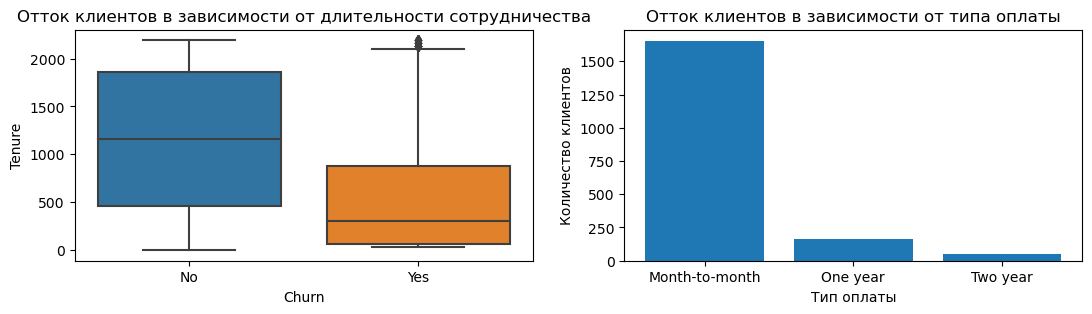

In [542]:
fig = plt.figure(figsize=(13, 3))

fig.add_subplot(1, 2, 1)
sns.boxplot(x = df['Churn'], y = df['Tenure'])
plt.title('Отток клиентов в зависимости от длительности сотрудничества')

fig.add_subplot(1, 2, 2)
plt.bar(df['Type'], df_ord.groupby('Type')['Churn'].transform('sum'))
plt.title('Отток клиентов в зависимости от типа оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество клиентов')

plt.show()

Предположения оказались верными, большинство клиентов решивших расторгнуть договор являлись относительно новыми клиентами и большинство клиентов расторгнувших договор с компанией действительно предпочитало ежемесячную оплату.

Рассмотрим зависимость целевого признака `Churn` от суммы ежемесячной оплаты и общей суммы оплаченной клиентом за услуги, при этом стоит отметить, что между признаками не наблюдалась явная корреляция.

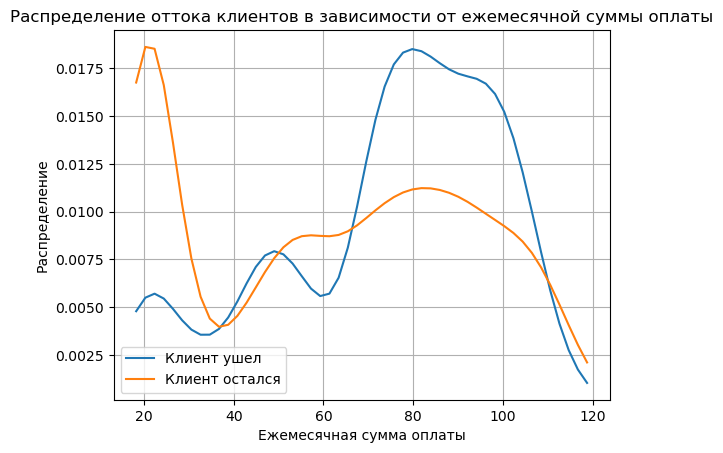

In [543]:
churn_yes = gaussian_kde(df[df['Churn'] == 'Yes']['MonthlyCharges'])
churn_no = gaussian_kde(df[df['Churn'] == 'No']['MonthlyCharges'])

min_value = df['MonthlyCharges'].min()
max_value = df['MonthlyCharges'].max()

x = np.linspace(min_value, max_value)

plt.plot(x, churn_yes(x), label='Клиент ушел')
plt.plot(x, churn_no(x), label='Клиент остался')
plt.legend(loc='lower left')
plt.xlabel('Ежемесячная сумма оплаты')
plt.ylabel('Распределение')
plt.title('Распределение оттока клиентов в зависимости от ежемесячной суммы оплаты')
plt.grid()

plt.show()

На графике мы можем наблюдать более высокую вероятность оттока клиентов при большей сумме оплаты.

Рассмотрим зависимость целевого признака `Churn` от общей суммы оплат.

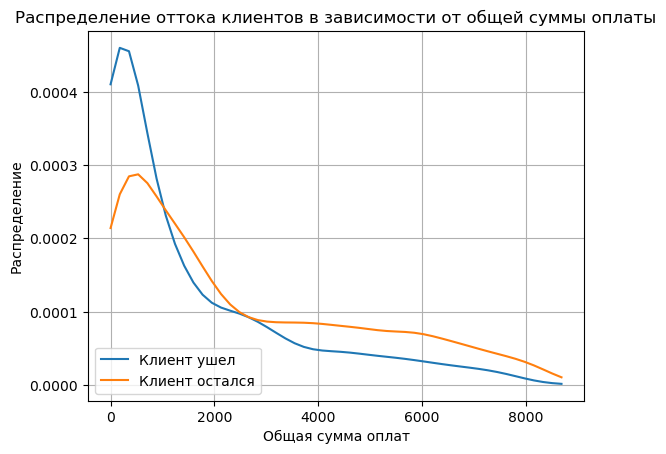

In [544]:
churn_yes = gaussian_kde(df[df['Churn'] == 'Yes']['TotalCharges'])
churn_no = gaussian_kde(df[df['Churn'] == 'No']['TotalCharges'])

min_value = df['TotalCharges'].min()
max_value = df['TotalCharges'].max()

x = np.linspace(min_value, max_value)

plt.plot(x, churn_yes(x), label='Клиент ушел')
plt.plot(x, churn_no(x), label='Клиент остался')
plt.legend(loc='lower left')
plt.xlabel('Общая сумма оплат')
plt.ylabel('Распределение')
plt.title('Распределение оттока клиентов в зависимости от общей суммы оплаты')
plt.grid()

plt.show()

На графике мы можем видеть более высокую вероятность оттока у клиентов с меньшей суммой общих платежей. 

#### Выводы.

В ходе исследовательского анализа, нам удалось получить более полное представление о данных. Были рассмотрены новые признаки: `Tenure` - количество дней сотрудничества клиента с компанией и `Churn` - целевой признак, сообщающий о том, продолжает ли клиент пользоваться услугами компании.

На графике `Churn` мы смогли обнаружить, что большинство клиентов в данных продолжает пользоваться услугами компании. Так как данный признак является целевым, дисбаланс классов при обучении может привести к большому количеству ложноотрицательных результатов. Нам следует учесть это при построении нашей модели.

Исследуя график `Tenure` мы смогли заметить два выброса в начале и конце графика говорящих о том, что большое количество клиентов сотрудничает с компанией меньше 250 дней, а другое большое количество клиентов пользуется услугами компании уже более 2000 дней. Мы сделали предположение, что у данного признака имеется корреляция с типом оплаты, что оказалось верным. 

Затем мы решили исследовать корреляцию между другими признаками датасета. Целевой признак `Churn` коррелирует с типом оплаты, продолжительностью пользования услугами, способом оплаты с помощью электронного чека и подключением интернета с помощью оптоволконного кабеля. В целом наблюдалась картина, что клиенты расторгнувшие договор с компанией пользуются услугами компании непродолжительный период и предпочитают ежемесячную оплату. Также интересным было отметить среднюю зависимость оттока клиентов со способом оплаты с помощью электронного чека, возможно что у клиентов могут возникать какие-то проблемы с данным способом оплаты из-за чего у них может возникнуть намерение отказаться от услуг, компании следует изучить данный вопрос.

На сумму ежемесячной очень сильно влияет наличие и способ интернет соединения, а также опции стримингов. Особо сильная корреляция наблюдается между способом подключения интернета через оптоволоконный кабель и суммой ежемясячной оплаты, учитывая что данный способ подключения наиболее сильно коррелирует со стоимостью ежемясячной оплаты, компании стоит присмотреться к ценовой политике, возможно конкуренты могут предложить более лояльные условия для подключения интернета по оптоволоконному кабелю.

Наличие опции стриминга также сильно коррелирует с опцией подключения антивируса.

Продолжительность пользования услугами сильно коррелирует с типом оплаты - ежемесячной или оплатой за два года. Клиенты предпочитающие тип оплаты за два года очевидно пользуются услугами компании дольше, в то же время клиенты с ежемесячным типом оплаты больше подвержены оттоку.

Из интересного также можно было бы отметить, что клиенты имеющие партнеров имеют среднюю корреляцию с продолжительностью сотрудничества с компанией. Также клиенты с партнерами с большей вероятностью имеют также иждевенца.

Пользователи с подключением интернета через телефонную линию с повышенной вероятностью воспользовавшиеся опцией блокировки опасных сайтов, а также склонны приобрести опцию технической поддержки. Подключение антивируса в свою очередь имеет среднюю корреляцию с услугой облачного резервного копирования, опцией технической поддержки и опциями стримингов.

Также были рассмотрены графики зависимости оттока клиентов от суммы ежемесячной и общей оплаты. Как и ожидалось на графиках мы смогли наблюдать более высокую вероятность оттока клиентов при большей сумме ежемесячной оплаты и более высокую вероятность оттока у клиентов с меньшей суммой общих платежей.

### Подготовка данных для моделей машинного обучения.

На этапе исследовательского анализа данных в данных была обнаружена мультиколлинеарность, которая может негативно повлиять на модель логистической регрессии. Для того чтобы уменшьшить мультиколлинеарность, мы воспользуемся методами регуляризации L1 или L2.

Также нами был замечен дисбаланс целевого признака, что может негативно сказаться на качестве моделей, особенно на модели логистической регрессии. Бороться с дисбалансом мы будем встроенными методами моделей, а именно параметром `class_weight='balanced'`, который автоматически рассчитает вес каждого класса в зависимости от пропорции количества экземпляров класса в обучающей выборке, тем самым уравновесив вклад каждого класса в процессе обучения.

Для начала разобьем датасет на тренировочную и тестовую выборку, а также выделим целевой признак. Воспользуемся датасетом с закодированнымм нами ранее признаками _df_ohe_ord_.

In [89]:
RANDOM_STATE = 130323

features = df.drop(['Churn'], axis=1)
target = df['Churn'].replace({'Yes': 1, 'No': 0})

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25,
                                                                            stratify=target,
                                                                            random_state=RANDOM_STATE)

One-Hot encoding

In [90]:
categorical_features = ['Type', 
                        'PaperlessBilling', 
                        'PaymentMethod',  
                        'Gender', 
                        'SeniorCitizen',
                        'Partner',
                        'Dependents',
                        'InternetService',
                        'OnlineSecurity', 
                        'OnlineBackup',
                        'DeviceProtection', 
                        'TechSupport', 
                        'StreamingTV', 
                        'StreamingMovies',
                        'MultipleLines']

numeric_features = ['MonthlyCharges', 'TotalCharges', 'Tenure']

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder.fit(features_train[categorical_features])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [91]:
features_train[encoder.get_feature_names_out()] = encoder.transform(features_train[categorical_features])
features_test[encoder.get_feature_names_out()] = encoder.transform(features_test[categorical_features])

features_train = features_train.drop(categorical_features, axis=1)
features_test = features_test.drop(categorical_features, axis=1)

Для модели логистической регрессии желательно произвести масштабирование признаков.

In [49]:
scaler = MinMaxScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

## Создание моделей.

Нашей задачей является разработка прототипа модели, которая подскажет с кем из клиентов следует поработать над удержанием, чтобы они не ушли от заказчика. Для данной цели мы протестируем три модели с помощью кросс-валидации из которых выберем лучшую: 
* Модель логистической регрессии
* Модель случайного леса
* Модель градиентного бустинга. 

Лучшую модель мы протестируем на тестовой выборке. В качестве показателя для оценки качества модели будем использовать метрику _ROC-AUC_.

### Модель логистической регрессии.

In [54]:
%%time

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

lin_model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

lin_parametrs = {'penalty':['l1', 'l2'],
                 'C': [0.1, 1, 10, 50, 100, 150], 
                 'max_iter': [100, 500, 1000, 1500], 
                 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                 'dual':[False, True]} 

lin_grid = GridSearchCV(lin_model, lin_parametrs, scoring='roc_auc')
lin_grid.fit(features_train_scaled, target_train)
print(f'Показатель метрики ROC-AUC модели логистической регрессии составил {lin_grid.best_score_:.2}')

# CPU times: total: 6min 31s
# Wall time: 1min 58s

Показатель метрики ROC-AUC модели логистической регрессии составил 0.84
CPU times: total: 6min 31s
Wall time: 1min 58s


### Модель случайного леса.

In [51]:
%%time

forest_model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

forest_parametrs = {'n_estimators': [200], 
                    'max_depth': range(5, 16, 2),
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'criterion': ['gini', 'entropy']}

forest_grid = GridSearchCV(forest_model, forest_parametrs, scoring='roc_auc')
forest_grid.fit(features_train, target_train)
print(f'Показатель метрики ROC-AUC модели случайного леса составил {forest_grid.best_score_:.2}')

# CPU times: total: 28min 18s
# Wall time: 28min 23s

Показатель метрики ROC-AUC модели случайного леса составил 0.86
CPU times: total: 28min 18s
Wall time: 28min 23s


### Модель градиентного бустинга (LightGBM).

In [57]:
%%time

lgb_model = lgb.LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')

lgb_parametrs = {'n_estimators': [200],
                 'max_depth': range(5, 20, 2),
                 'num_leaves': [31, 61, 91],
                 'learning_rate': [0.01, 0.05, 0.1],
                 'min_child_samples': [10, 20, 30],
                 'reg_alpha': [0, 0.1, 0.5],
                 'reg_lambda': [0, 0.1, 0.5]}

lgb_grid = GridSearchCV(lgb_model, lgb_parametrs, scoring='roc_auc')
lgb_grid.fit(features_train, target_train)
print(f'Показатель метрики ROC-AUC модели градиентного бустинга составил {lgb_grid.best_score_:.2}')

# CPU times: total: 4h 1min 44s
# Wall time: 31min 9s

Показатель метрики ROC-AUC модели градиентного бустинга составил 0.9
CPU times: total: 6h 23min 54s
Wall time: 53min 5s


### Анализ моделей.

Критерии, которые важны для заказчика:
  * качество предсказания;
  * время обучения модели;
  * время предсказания модели.

Проведем анализ моделей - сравним качество, время обучения и предсказания разных моделей.

#### Модель линейной регрессии.

In [58]:
results = lin_grid.cv_results_
best_index = lin_grid.best_index_

lin_fit_time = results['mean_fit_time'][best_index]
lin_score_time = results['mean_score_time'][best_index]
lin_best_score = lin_grid.best_score_

print(f"Время обучения модели: {lin_fit_time:.2}, Время предсказания модели: {lin_score_time:.2}, ROC-AUC: {lin_best_score:.2}")

Время обучения модели: 0.15, Время предсказания модели: 0.0036, ROC-AUC: 0.84


#### Модель случайного леса.

In [59]:
results = forest_grid.cv_results_
best_index = forest_grid.best_index_

forest_fit_time = results['mean_fit_time'][best_index]
forest_score_time = results['mean_score_time'][best_index]
forest_best_score = forest_grid.best_score_

print(f"Время обучения модели: {forest_fit_time:.2}, Время предсказания модели: {forest_score_time:.2}, ROC-AUC: {forest_best_score:.2}")

Время обучения модели: 1.0, Время предсказания модели: 0.068, ROC-AUC: 0.86


#### Модель градиентного бустинга (LightGBM).

In [60]:
results = lgb_grid.cv_results_
best_index = lgb_grid.best_index_

lgb_fit_time = results['mean_fit_time'][best_index]
lgb_score_time = results['mean_score_time'][best_index]
lgb_best_score = lgb_grid.best_score_

print(f"Время обучения модели: {lgb_fit_time:.2}, Время предсказания модели: {lgb_score_time:.2}, ROC-AUC: {lgb_best_score:.2}")

Время обучения модели: 0.23, Время предсказания модели: 0.012, ROC-AUC: 0.9


#### Сравнение результатов.

Сравним результаты обучения моделей.

In [61]:
result = pd.DataFrame(
    [[lin_best_score, lin_fit_time, lin_score_time], 
     [forest_best_score, forest_fit_time, forest_score_time], 
     [lgb_best_score, lgb_fit_time, lgb_score_time]], 
    index=['LogisticRegression', 'RandomForestRegressor', 'LightGBM'], 
    columns=['ROC-AUC', 'Время обучения', 'Время предсказания']
)
result

,ROC-AUC,Время обучения,Время предсказания
LogisticRegression,0.842837,0.154785,0.003591
RandomForestRegressor,0.859158,1.047997,0.068380
LightGBM,0.902693,0.229243,0.011702


По качеству предсказаний модель основанная на градиентном бустинге значительно превосходит другие модели. Время обучения модели градиентного бустинга меньше, чем у модели случайного леса и но немного выше линейной регресии. Время предсказания у модели градиентного бустинга ниже чем у модели случайного леса практически в 6 раз, однако выше чем у модели логистической регрессии.

Таким образом лучшей моделью по показателям можно назвать модель градиентного бустинга LightGBM.

### Тестирование лучшей модели.

Проверим качество модели LGBMClassifier на тестовой выборке.

In [62]:
predicted_proba = lgb_grid.predict_proba(features_test)[:, 1]
test_score = roc_auc_score(target_test, predicted_proba)
test_score

0.914501979608457

Значение метрики ROC-AUC на тестовой выборке составило 0.91

Построим графики ROC-кривой и матрицы ошибок.

In [95]:
fpr, tpr, _ = roc_curve(target_test, predicted_proba)
predicted_classes = lgb_grid.predict(features_test)
cm = confusion_matrix(target_test, predicted_classes)

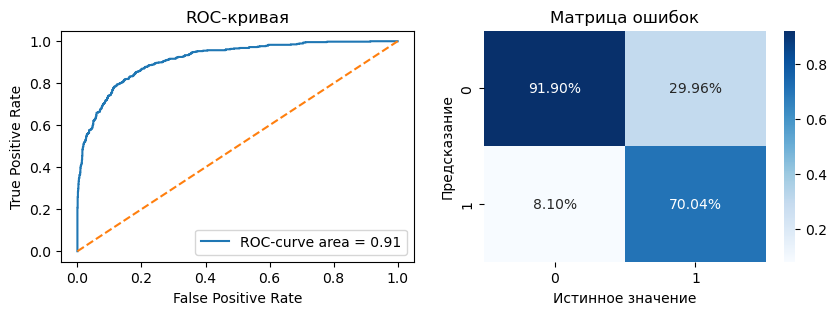

In [97]:
fig = plt.figure(figsize=(10, 3))

fig.add_subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC-curve area = {:.2}'.format(test_score))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

fig.add_subplot(1, 2, 2)
sns.heatmap(cm / sum(cm), annot=True, fmt='.2%', cmap = 'Blues')
plt.title('Матрица ошибок')
plt.xlabel('Истинное значение')
plt.ylabel('Предсказание')

plt.show()

На графике с матрицой ошибок можно заметить, что модель лучше предсказывает клиентов которые остались в компании, чем клиентов решивших расторгнуть договор. 

В нашем случае с оттоком клиентов, не лишним будет использовать метрику _Recall_, которая отражает насколько хорошо модель может идентифицировать все истинно-положительные случаи, ведь нам важно выделить клиентов решивших покинуть компанию, не так критично если среди предсказанных к оттоку клиентов окажутся клиенты, которые не были намерены покидать компанию, так как такому пользователю будут предложены промокоды и специальные условия. Однако следует помнить, что если ложно-отрицательных клиентов окажется слишком много, использование такой модели может быть невыгодным для компании. Для этого нам пригодится метрика _Precision_, которая отражает какая доля клиентов отмеченных как истинно-положительные действительно истинно-положительные. 

In [98]:
recall_score(target_test, predicted_classes)

0.7858672376873662

Значение _Recall_ равное 0.79 означает, что модель способна правильно идентифицировать 79% всех истинных положительных случаев в тестовом наборе данных. То есть, в данном случае, модель может распознать 79% клиентов, которые действительно намерены покинуть компанию, что может быть полезно для предотвращения оттока и улучшения удержания клиентов. 

In [99]:
precision_score(target_test, predicted_classes)

0.700381679389313

Значение _Precision_ равное 0.7 означает, что из всех клиентов, которых модель идентифицировала как ушедших, только 70% действительно являются истинными положительными случаями. То есть, есть риск того, что модель может ошибочно классифицировать некоторых клиентов как намеренных покинуть компанию, которые на самом деле покидать компанию не намерены.

Основываясь на этих данных, компания может решить выгодно ли для нее удержание таких клиентов.

### Исследование важности признаков лучшей модели.

In [101]:
feature_importances = pd.Series(lgb_grid.best_estimator_.feature_importances_, index=features_train.columns).sort_values(ascending=True)
feature_importances = feature_importances / sum(feature_importances)

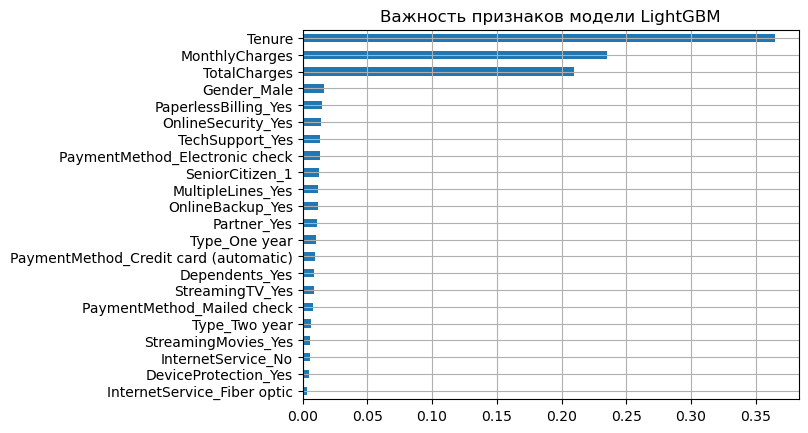

In [102]:
feature_importances.plot(kind='barh')
plt.title('Важность признаков модели LightGBM')
plt.grid()
plt.show()

Наиболее сильное влияние на отток клиентов, согласно нашей модели, оказывают:
* _Продолжительность сотрудничества клиента с компанией_ - самое сильное влияние, чем дольше клиент сотрудничает с компанией, тем меньше вероятность того, что он решит расторгнуть договор.
* _Сумма ежемесячной оплаты_ - клиенты с высокой суммы ежемесячной оплаты с большей вероятностью покинут компанию, чем клиенты предпочитающие оплату за год или два. Такое сильное влияние данного фактора несколько удивляет, так как мы не нашли высокой корреляции данного признака с вероятностью оттока клиентов на этапе исследовательского анализа данных.
* _Общая сумма оплат_ - клиенты, сумма общих оплат которых относительно велика, с более низкой вероятностью решатся покинуть компанию. 

Таким образом модель градиентного бустинга LightGBM выделила числовые признаки, как наиболее сильно влияющие на целевой признак. Можно предположить, что этому поспособствовала регуляризация признаков для борьбы с переобучением модели, так как в данных присутствовала мультиколлинеарность. Возможно это также связано с тем, что модель учитывает не только линейные зависимости между признаками и целевым признаком, но и нелинейные зависимости. В результате, даже если числовые признаки не имели явного линейного влияния на целевой признак, они все же могли вносить значительный вклад в предсказание модели.   

Обратив внимание на распределение категориальных признаков можно обнаружить, что наибольшее влияние на отток клиентов характерено для признаков так называемых "продвинутых пользователей", которые предпочитают безбумажное выставление счета, оплачивают с помощью электронного чека, пользуются услугами блокировки небезопасных сайтов.

Посмотрим как модель покажет себя, если обучить ее только на трех наиболее важных признаках.

In [103]:
funny_features_train = features_train[['Tenure', 'MonthlyCharges', 'TotalCharges']]
funny_features_test = features_test[['Tenure', 'MonthlyCharges', 'TotalCharges']]

In [104]:
lgb_grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 19,
 'min_child_samples': 10,
 'n_estimators': 200,
 'num_leaves': 31,
 'reg_alpha': 0.5,
 'reg_lambda': 0.1}

In [105]:
# Аргументы параметров модели такие же, как и у тестовой модели

funny_lgb_model = lgb.LGBMClassifier(random_state=RANDOM_STATE,
                                     class_weight='balanced', 
                                     learning_rate=0.1, 
                                     max_depth=19, 
                                     min_child_samples=10, 
                                     n_estimators=200, 
                                     num_leaves=31, 
                                     reg_alpha=0.5, 
                                     reg_lambda=0.1)

funny_lgb_model.fit(funny_features_train, target_train)

LGBMClassifier(class_weight='balanced', max_depth=19, min_child_samples=10,
               n_estimators=200, random_state=130323, reg_alpha=0.5,
               reg_lambda=0.1)

In [106]:
# Показатель метрики ROC-AUC

roc_auc_score(target_test, funny_lgb_model.predict_proba(funny_features_test)[:, 1])

0.9178839834996692

Удивительно, для качественных предсказаний модели хватило всего лишь трех численных признаков с продолжительностью сотрудничества, суммой ежемесячной оплаты и общей суммой оплат. Дело, как нам кажется, кроется в следующем. 

На этапе знакомства с данными мы обратили внимание, что несмотря на то, что компания ведет учет данных с 2014 года, отток клиентов фиксировался лишь последние 4 месяца с даты выгрузки данных (1 февраля 2020 года). Вероятно полные данные были утеряны, стоило бы уточнить у компании, действительно ли клиенты заключившие договор с компанией за прошедшие 6 лет, решили покинуть ее лишь в последние месяцы. Тем не менее, это объясняет то, почему модели достаточно лишь трех признаков с продолжительностью сотрудничества, суммой ежемесячной оплаты и общей суммой оплат для получения качественных предсказаний.

### Выводы.

На этапе создания модели для решения задачи предсказания оттока клиентов было протестировано три модели машинного обучения. 

* Модель логистической регрессии
* Модель случайного леса
* Модель градиентного бустинга.

Так как на этапе анализа данных в данных была обнаружена мультиколлинеарность, мы воспользовались методами регуляризации чтобы снизить ее влияние на качество моделей. Также нами был замечен дисбаланс целевого признака с которым мы боролись встроенными методами моделей, а именно параметром class_weight='balanced', который автоматически рассчитывает вес каждого класса в зависимости от пропорции количества экземпляров класса в обучающей выборке, тем самым уравновесив вклад каждого класса в процессе обучения.

Для выбора лучшей модели мы решили протестировать три модели с помощью кросс-валидации.

Оказалось, что по качеству предсказаний модель основанная на градиентном бустинге значительно превосходит другие модели, значение метрики ROC-AUC составило 0.9, второе место по качеству предсказаний занимет модель случайного леса с показателем метрики 0.86, значение метрики модели логиситческой регрессии составило 0.84. Время обучения модели градиентного бустинга оказалось меньше, чем у моделей случайного леса и модели линейной регресии и составило 0.2 секунды, у моделей логистической регрессии и случайного леса время обучения составило около 1 секунды. Время предсказания у модели градиентного бустинга также оказалось ниже чем у модели случайного леса практически в десять раз и составило, однако показатель оказался выше чем у модели логистической регрессии и тем не менее составил всего 0.007 секунды.

Таким образом лучшей моделью по показателям можно назвать модель градиентного бустинга LightGBM.

Затем мы протестировали лучшую модель на тестовой выборке, показатель метрики ROC-AUC составил 0.91.

Для лучшей модели мы провели дополнительный анализ на тестовых данных. На графике с матрицой ошибок мы смогли заметить, что модель лучше предсказывает клиентов которые остались в компании, чем клиентов решивших расторгнуть договор.

Также на тестовых данных мы измерили показатели метрик _Recall_ и _Precision_. Значение _Recall_ оказалось равным 0.79, то есть, в данном случае, модель смогла распознать 79% клиентов, которые действительно намерены покинуть компанию, что может быть полезно для предотвращения оттока и улучшения удержания клиентов. Значение _Precision_ оказалось равным 0.7 что означает, что из всех клиентов, которых модель идентифицировала как ушедших, только 70% действительно являются истинными положительными случаями. То есть, есть риск того, что модель может ошибочно классифицировать некоторых клиентов как намеренных покинуть компанию, которые на самом деле покидать компанию не намерены. Основываясь на этих данных, компания может решить выгодно ли для нее удержание таких клиентов.

Было также произведено исследование важности признаков для предсказаний лучшей модели. 
Оказалось, что наиболее сильное влияние на отток клиентов оказывают:

* Продолжительность сотрудничества клиента с компанией - самое сильное влияние, чем дольше клиент сотрудничает с компанией, тем меньше вероятность того, что он решит расторгнуть договор.
* Сумма ежемесячной оплаты - клиенты с высокой суммой ежемесячной оплаты с большей вероятностью покинут компанию, чем клиенты предпочитающие оплату за год или два. 
* Общая сумма оплат - клиенты, сумма общих оплат которых относительно велика, с более низкой вероятностью решатся покинуть компанию.
Таким образом модель градиентного бустинга LightGBM выделила числовые признаки, как наиболее сильно влияющие на целевой признак. Можно предположить, что этому поспособствовала регуляризация признаков для борьбы с переобучением модели, так как в данных присутствовала мультиколлинеарность. Возможно это также связано с тем, что модель учитывает не только линейные зависимости между признаками и целевым признаком, но и нелинейные зависимости. В результате, даже если числовые признаки не имели явного линейного влияния на целевой признак, они все же могли вносить значительный вклад в предсказание модели.

Мы решили обучить тестируемую модель на данных в которых оставили только три самых важных признака, и показатель метрики составил 0.9185, что совсем немного уступает показателю модели обученной на всех имеющихся признаках. Дело, как нам кажется, кроется в следующем - на этапе знакомства с данными мы обратили внимание, что несмотря на то, что компания ведет учет данных с 2014 года, отток клиентов фиксировался лишь последние 4 месяца с даты выгрузки данных (1 февраля 2020 года). Вероятно полные данные были утеряны, стоило бы уточнить у компании, действительно ли клиенты заключившие договор с компанией за прошедшие 6 лет, решили покинуть ее лишь в последние месяцы. Тем не менее, это объясняет то, почему модели достаточно лишь трех признаков с продолжительностью сотрудничества, суммой ежемесячной оплаты и общей суммой оплат для получения качественных предсказаний.



## Отчет.

Исходный план проекта содержал следующие пункты.

* __Подготовка данных__
  * __Знакомство с данными__ (подгрузка файлов, изучение предоставленных данных, построение графиков распределения признаков)
  * __Предобработка данных__ (поиск аномальных значений признаков, слияние датафреймов, заполнение пропусков, преобразование типов и нормализация)
  * __Исследовательский анализ данных__ (визуализация данных, поиск корреляций между признаками)
  * __Подготовка данных для моделей машинного обучения__ (разделение на выборки, кодирование, масштабирование)<br><br>
* __Создание моделей__ (логистическая регрессия, random forest, градиентный бустинг, возможно нейросеть)
  * __Поиск лучших гипперпараметров каждой модели__
  * __Сравнение метрик моделей на кросс-валидации__
  * __Тестирование лучшей модели__
  * __Исследование важности признаков для лучшей модели__

В ходе исследования мы придерживались исходным пунктам нашего плана.

На этапе подготовки данных мы изучили предоставленные файлы с данными с информацией о договоре, персональными данные клиента, информацией об интернет-услугах, информацей об услугах телефонии. Для каждого файла был построен график с распределениями признаков.

* В файле с информацией о договорах клиентов на графиках мы заметили, что большинство клиентов предпочитают ежемесячную оплату, вместо оплаты за год или два. Большинство клиентов предпочитают оплату с помощью электронного чека. Количество клиентов предпочитающих безбумажное выставление счета на 25% больше количества клиентов, которым необходимо бумажное выставление счета. На графике с суммой ежемесячной оплаты клиентов мы смогли заметить выброс в значении до 30. График с общей суммой распределен со скосом вправо. На графиках с датами можно было заметить приток клиентов в 2020 году, что вероятно объясняет выбросы на графиках с небольшой суммой ежемесячной и общей оплаты. Нас удивил тот факт, что несмотря на то что компания начала заключать договоры с клиентами примерно с 2014 года, расторжение контрактов приходится лишь на последние 4 месяца с момента выгрузки данных.

* На графиках файла с персональной информацией о клиентах мы смогли заметить равное распределение в столбцах `gender` и `Partner`. Количество пенсионеров примерно в 6 раз меньше клиентов непенсионеров. Количество клиентов примерно содержащих иждевенцев в 2.5 раза меньше клиентов без иждевенцев.

* В файле с информацией об интернет-услугах мы смогли заметить, что клиентов предпочитающих подключение через оптоволоконный кабель примерно на 20% больше, чем клиентов использующих телефонную линию в качестве соединения. Половина клиентов пользуются услугами стримингов. Большинство клиентов не пользуются услугами интернет-безопасности и услугами облачного резервного копирования данных. Файл с информацией об интернет-услугах содержит 5517 строк с уникальными записями о клиентах.

* Файл с информацией об услугах телефонии содержит 6361 строк с уникальными записями о клиентах. На графике мы смогли заметить небольшой перевес в сторону клиентов не пользующихся услугами нескольких линий телефонной связи.


------


В ходе предобработки данных были создали новые признаки: `churn` - целевой категориальный признак отражающий отток клиентов и `tenure` - значениями которого являются количество дней с момента заключения договора до момента его расторжения или до момента для которого данные были актуальны (1 февраля 2020). Также нам пришлось удалить некоторые признаки, чтобы не допустить утечки данных. В одной из колонок были обнаружены пропуски, строки с которыми мы решили удалить, так как это оказались новые клиенты заключившие договор в тот же день, в который была произведена выгрузка данных. Для удобства дальнейшей работы мы объединили файлы с данными в один датафрейм.


-----


На этапе исследовательского анализа, нам удалось получить более полное представление о данных. Были рассмотрены новые признаки из которых выяснилось, большинство клиентов продолжает пользоваться услугами компании. Исследуя график Tenure мы смогли заметить два выброса в начале и конце графика. Мы сделали предположение, что у данного признака имеется корреляция с типом оплаты, что оказалось верным.

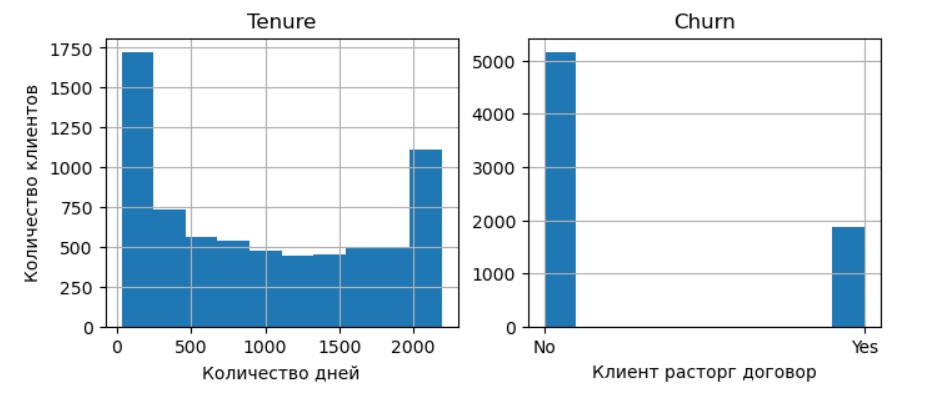

Затем мы решили исследовать корреляцию между признаками датасета. Оказалось, что целевой признак `Churn` коррелирует с типом оплаты, продолжительностью пользования услугами, способом оплаты с помощью электронного чека и подключением интернета с помощью оптоволконного кабеля. В целом наблюдалась картина, что клиенты расторгнувшие договор с компанией пользуются услугами компании непродолжительный период и предпочитают ежемесячную оплату. Также интересным было отметить среднюю зависимость оттока клиентов со способом оплаты с помощью электронного чека, возможно что у клиентов могут возникать какие-то проблемы с данным способом оплаты из-за чего у них может возникнуть намерение отказаться от услуг, компании следует изучить данный вопрос.

Продолжительность пользования услугами сильно коррелирует с типом оплаты - ежемесячной или оплатой за два года. Клиенты предпочитающие тип оплаты за два года очевидно пользуются услугами компании дольше, в то же время клиенты с ежемесячным типом оплаты больше подвержены оттоку.

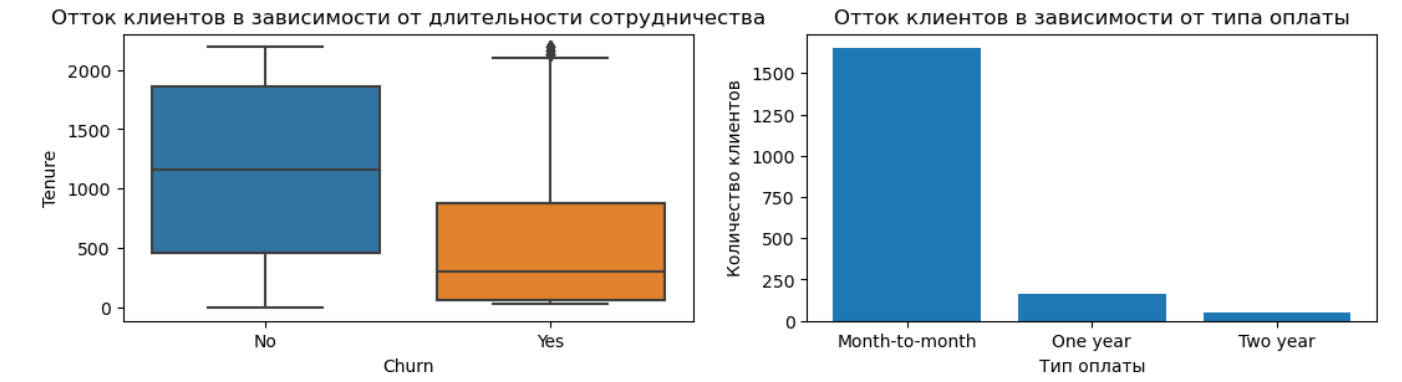

Также были рассмотрены графики зависимости оттока клиентов от суммы ежемесячной и общей оплаты. Как и ожидалось на графиках мы смогли наблюдать более высокую вероятность оттока клиентов при большей сумме ежемесячной оплаты и более высокую вероятность оттока у клиентов с меньшей суммой общих платежей.

----



Перед созданием модели мы разделили данные на обучающую и тестовую выборки, выделили целевой признак. Затем данные были закодированы с помощью техники прямого кодирования. Для линейной модели использовалсь данные с отмасштабированными численными признаками. 

На этапе создания модели для решения задачи предсказания оттока клиентов было протестировано три модели машинного обучения. 

* Модель логистической регрессии
* Модель случайного леса
* Модель градиентного бустинга.

Так как на этапе анализа данных в данных была обнаружена мультиколлинеарность, мы воспользовались методами регуляризации чтобы снизить ее влияние на качество моделей. Также нами был замечен дисбаланс целевого признака с которым мы боролись встроенными методами моделей, а именно параметром class_weight='balanced', который автоматически рассчитывает вес каждого класса в зависимости от пропорции количества экземпляров класса в обучающей выборке, тем самым уравновесив вклад каждого класса в процессе обучения.

Для выбора лучшей модели мы решили протестировать три модели с помощью кросс-валидации.

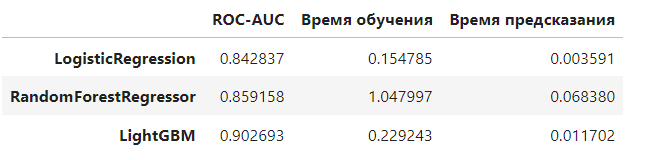

Оказалось, что по качеству предсказаний модель основанная на градиентном бустинге значительно превосходит другие модели, значение метрики ROC-AUC составило 0.9, второе место по качеству предсказаний занимет модель случайного леса с показателем метрики 0.86, значение метрики модели логиситческой регрессии составило 0.84.

Таким образом лучшей моделью по показателям можно назвать модель градиентного бустинга LightGBM.

Гиперпараметры модели следующие: {'learning_rate': 0.1,
 'max_depth': 19,
 'min_child_samples': 10,
 'n_estimators': 200,
 'num_leaves': 31,
 'reg_alpha': 0.5,
 'reg_lambda': 0.1}

-----

Затем мы протестировали лучшую модель на тестовой выборке, показатель метрики ROC-AUC составил 0.91.

Для лучшей модели мы провели дополнительный анализ на тестовых данных. На графике с матрицой ошибок мы смогли заметить, что модель лучше предсказывает клиентов которые остались в компании, чем клиентов решивших расторгнуть договор.

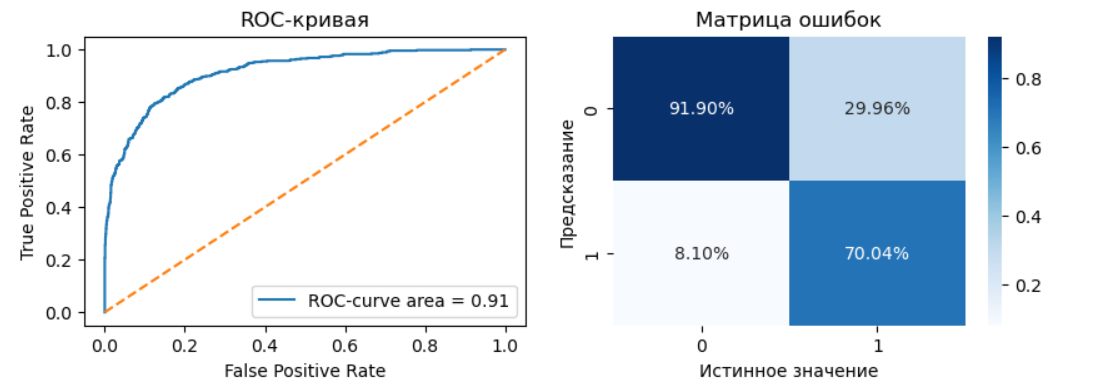

Также на тестовых данных мы измерили показатели метрик _Recall_ и _Precision_. Значение _Recall_ оказалось равным 0.79, то есть, в данном случае, модель смогла распознать 79% клиентов, которые действительно намерены покинуть компанию, что может быть полезно для предотвращения оттока и улучшения удержания клиентов. Значение _Precision_ оказалось равным 0.7 что означает, что из всех клиентов, которых модель идентифицировала как ушедших, только 70% действительно являются истинными положительными случаями. То есть, есть риск того, что модель может ошибочно классифицировать некоторых клиентов как намеренных покинуть компанию, которые на самом деле покидать компанию не намерены. Основываясь на этих данных, компания может решить выгодно ли для нее удержание таких клиентов.

Было также произведено исследование важности признаков для предсказаний лучшей модели. 
Оказалось, что наиболее сильное влияние на отток клиентов оказывают:

* Продолжительность сотрудничества клиента с компанией - самое сильное влияние, чем дольше клиент сотрудничает с компанией, тем меньше вероятность того, что он решит расторгнуть договор.
* Сумма ежемесячной оплаты - клиенты с высокой суммой ежемесячной оплаты с большей вероятностью покинут компанию, чем клиенты предпочитающие оплату за год или два. 
* Общая сумма оплат - клиенты, сумма общих оплат которых относительно велика, с более низкой вероятностью решатся покинуть компанию.

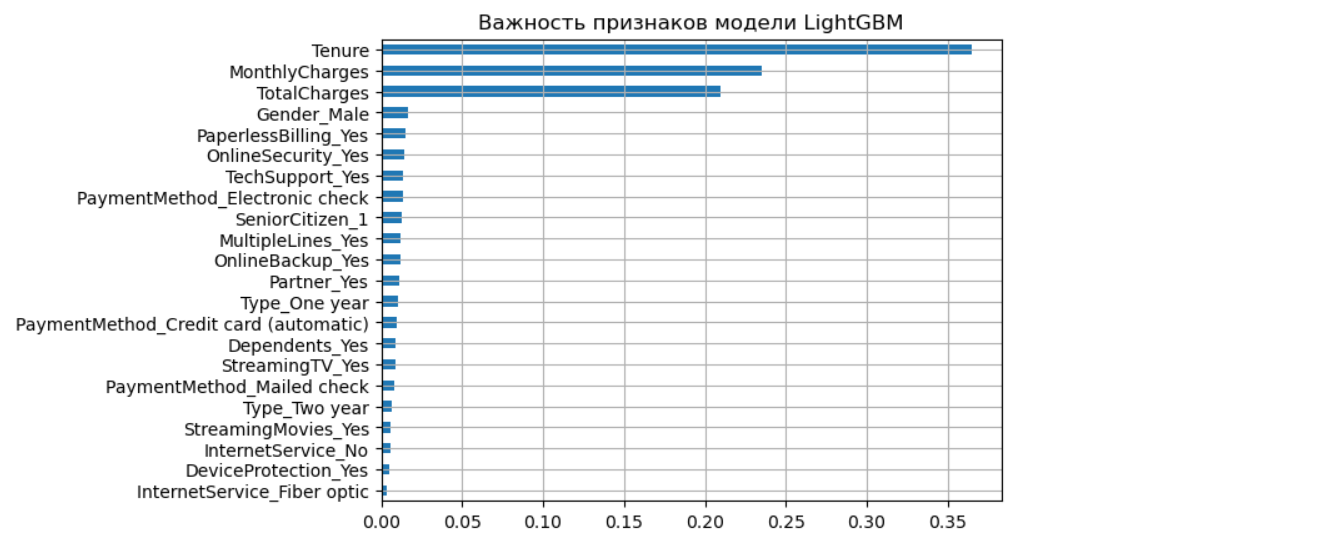

Таким образом модель градиентного бустинга LightGBM выделила числовые признаки, как наиболее сильно влияющие на целевой признак. Можно предположить, что этому поспособствовала регуляризация признаков для борьбы с переобучением модели, так как в данных присутствовала мультиколлинеарность. Возможно это также связано с тем, что модель учитывает не только линейные зависимости между признаками и целевым признаком, но и нелинейные зависимости. В результате, даже если числовые признаки не имели явного линейного влияния на целевой признак, они все же могли вносить значительный вклад в предсказание модели.

Мы решили обучить тестируемую модель на данных в которых оставили только три самых важных признака, и показатель метрики ROC-AUC составил впечатляющие 0.9179. Дело, как нам кажется, кроется в следующем - на этапе знакомства с данными мы обратили внимание, что несмотря на то, что компания ведет учет данных с 2014 года, отток клиентов фиксировался лишь последние 4 месяца с даты выгрузки данных (1 февраля 2020 года). Вероятно полные данные были утеряны, стоило бы уточнить у компании, действительно ли клиенты заключившие договор с компанией за прошедшие 6 лет, решили покинуть ее лишь в последние месяцы. Тем не менее, это объясняет то, почему модели достаточно лишь трех признаков с продолжительностью сотрудничества, суммой ежемесячной оплаты и общей суммой оплат для получения качественных предсказаний.

Таким образом, в ходе проделанной работы нам удалось создать прототип модели для прогнозирования оттока клиентов для компании «Ниединогоразрыва.ком» на имеющихся данных с удовлетворительным качеством метрики. Однако, следует учитывать, что в ходе проделанной работы у нас возникли некоторые сомнения в качестве предоставленных данных, а именно в том, что данные с датой расторжения договоров были предоставлены в полном объеме.